<a href="https://colab.research.google.com/github/milvus-io/bootcamp/blob/master/tutorials/quickstart/text_image_search_with_milvus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>   <a href="https://github.com/milvus-io/bootcamp/blob/master/tutorials/quickstart/text_image_search_with_milvus.ipynb" target="_blank">
    <img src="https://img.shields.io/badge/View%20on%20GitHub-555555?style=flat&logo=github&logoColor=white" alt="GitHub Repository"/>

# Text-to-Image Search with Milvus

Text-to-image search is an advanced technology that allows users to search for images using natural language text descriptions. It leverages a pretrained multimodal model to convert both text and images into embeddings in a shared semantic space, enabling similarity-based comparisons.

In this tutorial, we will explore how to implement text-based image retrieval using OpenAI’s CLIP (Contrastive Language-Image Pretraining) model and Milvus. We will generate image embeddings with CLIP, store them in Milvus, and perform efficient similarity searches.


## Prerequisites

Before you start, make sure you have all the required packages and example data ready.

### Install dependencies
- **pymilvus>=2.4.2** for interacting with the Milvus database
- **clip** for working with the CLIP model
- **pillow** for image processing and visualization

In [1]:
! pip install --upgrade pymilvus pillow
! pip install git+https://github.com/openai/CLIP.git

> If you're using Google Colab, you may need to **restart the runtime** (Navigate to the "Runtime" menu at the top of the interface, and select "Restart session" from the dropdown menu.)

### Download example data

We will use a subset of the [ImageNet](https://www.image-net.org) dataset (100 classes, 10 images for each class) as example images. The following command will download the example data and extract it to the local folder `./images_folder`:

In [2]:
! wget https://github.com/towhee-io/examples/releases/download/data/reverse_image_search.zip
! unzip -q reverse_image_search.zip -d images_folder

### Set up Milvus

Before proceeding, set up your Milvus server and connect using your URI (and optionally, a token):

- **Milvus Lite (Recommended for Convenience)**: Set the URI to a local file, such as ./milvus.db. This automatically leverages [Milvus Lite](https://milvus.io/docs/milvus_lite.md) to store all data in a single file.

- **Docker or Kubernetes (For Large-Scale Data)**: For handling larger datasets, deploy a more performant Milvus server using [Docker or Kubernetes](https://milvus.io/docs/quickstart.md). In this case, use the server URI, such as http://localhost:19530, to connect.

- **Zilliz Cloud (Managed Service)**: If you’re using [Zilliz Cloud](https://zilliz.com/cloud), Milvus’s fully managed cloud service, set the the Public Endpoint as URI and API Key as token.

In [3]:
from pymilvus import MilvusClient

milvus_client = MilvusClient(uri="milvus.db")

## Getting Started

Now that you have the necessary dependencies and data, it's time to set up feature extractors and start working with Milvus. This section will walk you through the key steps of building a text-to-image search system. Finally, we’ll demonstrate how to retrieve and visualize images based on text queries.

### Define feature extractors

We will use a pretrained CLIP model to generate image and text embeddings. In this section, we load the pretrained **ViT-B/32** variant of CLIP and define helper functions for encoding image and text:

- `encode_image(image_path)`: Processes and encodes images into feature vectors
- `encode_text(text)`: Encodes text queries into feature vectors

Both functions normalize the output features to ensure consistent comparisons by converting vectors to unit length, which is essential for accurate cosine similarity calculations.

In [4]:
import clip
from PIL import Image


# Load CLIP model
model_name = "ViT-B/32"
model, preprocess = clip.load(model_name)
model.eval()


# Define a function to encode images
def encode_image(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0)
    image_features = model.encode_image(image)
    image_features /= image_features.norm(
        dim=-1, keepdim=True
    )  # Normalize the image features
    return image_features.squeeze().tolist()


# Define a function to encode text
def encode_text(text):
    text_tokens = clip.tokenize(text)
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(
        dim=-1, keepdim=True
    )  # Normalize the text features
    return text_features.squeeze().tolist()

### Data Ingestion

To enable semantic image search, we first need to generate embeddings for all images and store them in a vector database for efficient indexing and retrieval. This section provides a step-by-step guide to ingesting image data into Milvus.


**1. Create Milvus Collection**

Before storing image embeddings, you need to create a Milvus collection. The following code demonstrates how to create a collection using [quick start mode](https://milvus.io/docs/create-collection-instantly.md) with the default COSINE metric type. The collection includes the following fields:

- `id`: A primary field with auto ID enabled.

- `vector`: A field for storing floating-point vector embeddings.

If you need a custom schema, refer to the [Milvus documentation](https://milvus.io/docs/create-collection.md) for detailed instructions.

In [5]:
collection_name = "image_collection"

# Drop the collection if it already exists
if milvus_client.has_collection(collection_name):
    milvus_client.drop_collection(collection_name)

# Create a new collection in quickstart mode
milvus_client.create_collection(
    collection_name=collection_name,
    dimension=512,  # this should match the dimension of the image embedding
    auto_id=True,  # auto generate id and store in the id field
    enable_dynamic_field=True,  # enable dynamic field for scalar fields
)

**2. Insert Data into Milvus**

In this step, we use a predefined image encoder to generate embeddings for all JPEG images in the example data directory. These embeddings are then inserted into the Milvus collection, along with their corresponding file paths. Each entry in the collection consists of:  

- **Embedding vector**: The numerical representation of the image. Stored in the field `vector`.  
- **File path**: The location of the image file for reference. Stored in the field `filepath` as a dynamic field.

In [6]:
import os
from glob import glob


image_dir = "./images_folder/train"
raw_data = []

for image_path in glob(os.path.join(image_dir, "**/*.JPEG")):
    image_embedding = encode_image(image_path)
    image_dict = {"vector": image_embedding, "filepath": image_path}
    raw_data.append(image_dict)
insert_result = milvus_client.insert(collection_name=collection_name, data=raw_data)

print("Inserted", insert_result["insert_count"], "images into Milvus.")

Inserted 1000 images into Milvus.


### Peform a Search

Now, let's run a search using an example text query. This will retrieve the most relevant images based on their semantic similarity to the given text description.

In [7]:
query_text = "a white dog"
query_embedding = encode_text(query_text)

search_results = milvus_client.search(
    collection_name=collection_name,
    data=[query_embedding],
    limit=10,  # return top 10 results
    output_fields=["filepath"],  # return the filepath field
)

Visualize results:

Query text: a white dog

Search results:


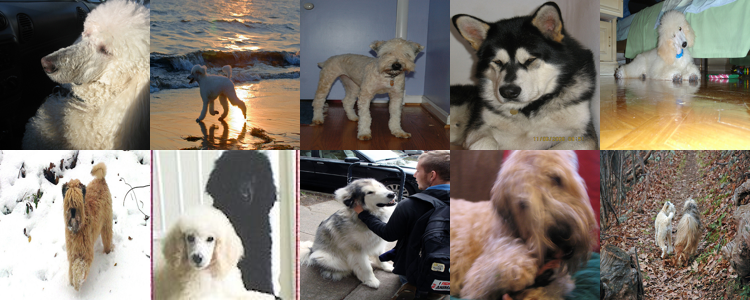

In [8]:
from IPython.display import display


width = 150 * 5
height = 150 * 2
concatenated_image = Image.new("RGB", (width, height))

result_images = []
for result in search_results:
    for hit in result:
        filename = hit["entity"]["filepath"]
        img = Image.open(filename)
        img = img.resize((150, 150))
        result_images.append(img)

for idx, img in enumerate(result_images):
    x = idx % 5
    y = idx // 5
    concatenated_image.paste(img, (x * 150, y * 150))
print(f"Query text: {query_text}")
print("\nSearch results:")
display(concatenated_image)